In [77]:
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as anp
from autograd.numpy.linalg import solve, norm
from autograd import grad, jacobian

In [69]:
def newton(x_0, f, f_prime, tol=1e-5, niter=15):
    current_iter = 0
    while current_iter < niter:
        if f_prime(x_0) == 0:
            raise ValueError('The sequence does not converge since f_double_prime(x_{}) = 0'.format(current_iter))
        x_1 = x_0 - (f(x_0) / f_prime(x_0))
        if abs(x_1 - x_0) < tol:
            return x_1
        x_0 = x_1
        current_iter += 1
    return x_1

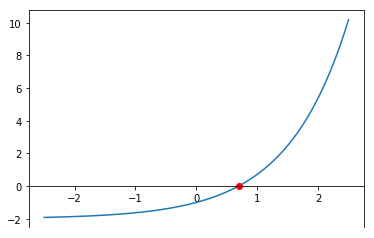

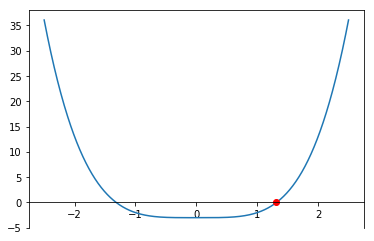

In [70]:
root1 = newton(3, lambda x: np.exp(x) - 2, lambda x: np.exp(x))
root2 = newton(3, lambda x: x**4 - 3, lambda x: 4*x**3)
domain = np.linspace(-2.5, 2.5, 1000)
ax = plt.gca()
ax.spines["bottom"].set_position("zero")
plt.plot(domain, np.exp(domain) - 2)
plt.plot(root1, np.exp(root1) - 2, 'ro')
plt.show()
ax = plt.gca()
ax.spines["bottom"].set_position("zero")
plt.plot(domain, domain**4 - 3)
plt.plot(root2, root2**4 - 3, 'ro')
plt.show()

In [71]:
def r(N_1, N_2, P_1, P_2):
    f = lambda x: P_1*((1 + x)**N_1 - 1) - P_2*(1 - (1 + x)**(-N_2))
    f_prime = lambda x: P_1*(N_1*(1 + x)**(N_1 - 1)) - P_2*(N_2*(1 + x)**(-N_2 - 1))
    return newton(0.1, f, f_prime)

r(30, 20, 2000, 8000)

0.03877843223027749

In [72]:
def newton_backtracking(x_0, f, f_prime, alpha=1, tol=1e-5, niter=15):
    current_iter = 0
    while current_iter < niter:
        if f_prime(x_0) == 0:
            raise ValueError('The sequence does not converge since f_double_prime(x_{}) = 0'.format(current_iter))
        x_1 = x_0 - alpha * (f(x_0) / f_prime(x_0))
        if abs(x_1 - x_0) < tol:
            return x_1, current_iter
        x_0 = x_1
        current_iter += 1
    return x_1, current_iter

f = lambda x: anp.sign(x) * anp.power(anp.abs(x), 1./3)
f_prime = grad(f)

print(newton_backtracking(0.01, f, f_prime, niter=100)) #diverges
print(newton_backtracking(0.01, f, f_prime, alpha=0.4, niter=100)) #converges to 0

(1.267650600228552e+28, 100)
(6.3999999999999218e-07, 5)


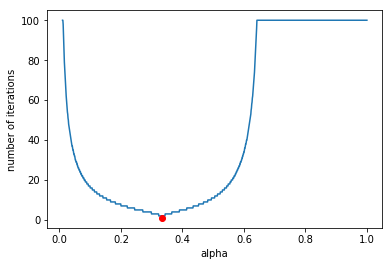

0.3330630630630631

In [73]:
def newton_alphas(x_0, f, f_prime, density=1000, tol=1e-5, niter=100):
    alphas = np.linspace(0.01, 1, density)
    iter_arr = np.empty(density)
    for i in range(density):
        iter_arr[i] = newton_backtracking(x_0, f, f_prime, alpha=alphas[i], tol=tol, niter=niter)[1]
    min_alpha = alphas[np.argmin(iter_arr)]
    plt.plot(alphas, iter_arr)
    plt.plot(min_alpha, np.min(iter_arr), 'ro')
    plt.ylabel('number of iterations')
    plt.xlabel('alpha')
    plt.show()
    return min_alpha

f = lambda x: anp.sign(x) * anp.power(anp.abs(x), 1./3)
f_prime = grad(f) 
    
newton_alphas(0.01, f, f_prime)

In [90]:
def newton_Rn(x_0, f, Df, alpha=1, tol=1e-5, niter=15):
    if np.isscalar(x_0):
        return newton(x_0, f, Df, tol=tol, niter=niter)
    else:
        current_iter = 0
        while current_iter < niter:
            y_0 = solve(Df(x_0), f(x_0))
            x_1 = x_0 - alpha * y_0
            if norm(x_1 - x_0) < tol:
                return x_1
            x_0 = x_1
            current_iter += 1
        return x_1

f = lambda x: anp.array([anp.sign(x[0]) * anp.power(anp.abs(x[0]), 1./3), anp.sign(x[1]) * anp.power(anp.abs(x[1]), 1./3)])
Df = jacobian(f)

#Converges to (0, 0) as expected.
print(newton_Rn(anp.array([0.01, 0.01]), f, Df, alpha=0.333))

#Converges to log(2) as expected.
print(newton_Rn(3, lambda x: np.exp(x) - 2, lambda x: np.exp(x)))

[  1.00000000e-11   1.00000000e-11]
0.69314718056


In [116]:
f = lambda x: anp.array([5*x[0]*x[1] - x[0]*(1 + x[1]), -x[0]*x[1] + (1 - x[1])*(1 + x[1])])
Df = jacobian(f)

def find_x_0(f, Df, density=100, niter=100):
    x_domain = np.linspace(-0.25, 0, density)
    y_domain = np.linspace(0, 0.25, density)
    X, Y = np.meshgrid(x_domain, y_domain)
    xy_domain = zip(X.ravel(), Y.ravel())
    for coord in xy_domain:
        try:
            minimizer1 = newton_Rn(anp.array(coord), f, Df, alpha=1, niter=niter)
            minimizer2 = newton_Rn(anp.array(coord), f, Df, alpha=0.55, niter=niter)
            if (np.allclose(minimizer1, anp.array((0, 1))) or np.allclose(minimizer1, anp.array((0, -1)))) and np.allclose(minimizer2, anp.array((3.75, 0.25))):
                return coord
        except:
            pass

find_x_0(f, Df)

(-0.25, 0.19696969696969699)

In [117]:
#To confirm:
print(newton_Rn(anp.array((-0.25, 0.19696969696969699)), f, Df, alpha=1, niter=100))
print(newton_Rn(anp.array((-0.25, 0.19696969696969699)), f, Df, alpha=0.55, niter=100))

[ -9.99014460e-23  -1.00000000e+00]
[ 3.75000599  0.25000187]


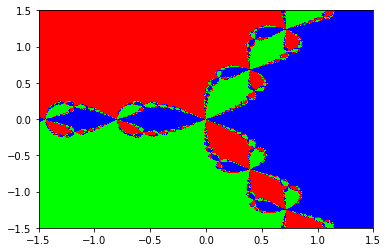

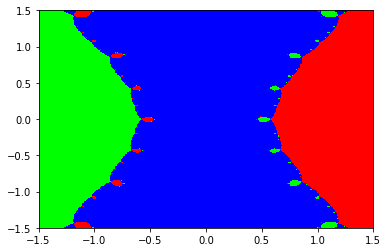

In [144]:
def basins(f, f_prime, roots, bounds, res, iters):
    r_min, r_max, i_min, i_max = bounds
    x_real = np.linspace(r_min, r_max, res) # Real parts.
    x_imag = np.linspace(i_min, i_max, res) # Imaginary parts.
    X_real, X_imag = np.meshgrid(x_real, x_imag)
    X_0 = X_real + 1j*X_imag # Combine real and imaginary parts.
    current_iter = 0
    while current_iter < iters:
        X_1 = X_0 - f(X_0)/f_prime(X_0)
        X_0 = X_1
        current_iter += 1
    Y = np.fromiter((np.argmin(abs(roots - i)) for i in X_1.ravel()), dtype=np.int64, count=res**2).reshape((res, res))
    plt.pcolormesh(X_real, X_imag, Y, cmap="brg")
    plt.show()
    
basins(lambda x: x**3 - 1, lambda x: 3*x**2, [1, -0.5 + 1j*((3 ** 0.5) / 2), -0.5 - 1j*((3 ** 0.5) / 2)], [-1.5, 1.5, -1.5, 1.5], 500, 100)
basins(lambda x: x**3 - x, lambda x: 3*x**2 - 1, [0, 1, -1], [-1.5, 1.5, -1.5, 1.5], 500, 100)
